In [1]:
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from PIL import Image
import cv2
import minigrid

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

from sentence_transformers import SentenceTransformer
lang_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)
                
# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, mask=False, output_mod=None):
        super().__init__()
        self.mask = mask
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None) # => hidden_size
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=8,stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32,64,kernel_size=4,stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64,32,kernel_size=3,stride=1), nn.LeakyReLU(inplace=True), Flatten(), nn.BatchNorm1d(32), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, hidden_size) #(b_size,32*1*1)=>(b_size,hidden_size)
        )
        self.process = mlp(hidden_size*2, 1*36*36, hidden_dim=1000, hidden_depth=1, output_mod=nn.Sigmoid()) #(b_size,hidden_size*2)=>(b_size,32*1*1)
        # UNet deconv mask --------------------------------------------------------------------------------------------------
        #self.deconv = nn.Sequential(
        #    nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32*1*1)=>(b_size,64,3,3)
        #    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,64,3,3)=>(b_size,32,8,8)
        #    nn.ConvTranspose2d(32, 1, kernel_size=8, stride=4), nn.Sigmoid(), #(b_size,32,8,8)=>(b_size,3,36,36)
        #)
        self.cnntrunk = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True), nn.BatchNorm2d(32), #(b_size,3,36,36)=>(b_size,32,8,8)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True), nn.BatchNorm2d(64), #(b_size,32,8,8)=>(b_size,64,3,3)
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.LeakyReLU(inplace=True), nn.BatchNorm2d(32), Flatten(), #(b_size,64,3,3)=>(b_size,32,1,1)=>(b_size,32*1*1)
            nn.Linear(32*1*1, action_dim)#, nn.LeakyReLU(inplace=True), nn.BatchNorm1d(32), #(b_size,32*1*1)=>(b_size,hidden_size)
            #nn.Linear(32, action_dim) #(b_size,hidden_size)=>(b_size,action_dim)
        )
        self.mlptrunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1) #(b_size,hidden_size*2)=>(b_size,action_dim)
        self.apply(weight_init)

    def forward(self, goal, state):
        state = state/255.0 # process image + switch channels
        state = state.permute(0,3,1,2)
        state_embed = self.conv(state)
        goal_embed = self.goal(goal) # process goal
        goal_state = torch.cat((goal_embed,state_embed),dim=1) # process goal + state
        
        if self.mask:
            img_mask = self.process(goal_state)
            img_mask = img_mask.reshape(-1,1,36,36)
            #img_mask = img_mask.reshape(-1,32,1,1)
            #img_mask = self.deconv(img_mask) # deconv for mask
            #--------------------- test with gt mask
            #img_mask = gt_mask.reshape((-1, 36, 36, 1)) # reshape to 1 channel
            #img_mask = np.repeat(img_mask, 3, axis=3) # duplicate across 3 channels
            #img_mask = img_mask.permute(0,3,1,2) # process channel switch
            #---------------------
            masked_state = state * img_mask # apply mask to full state
            pred = self.cnntrunk(masked_state)
            return [pred, masked_state, img_mask]
        else:
            pred = self.mlptrunk(goal_state)
            return [pred]

In [3]:
def show_step(obs):
    plt.figure()
    plt.imshow(obs)

def test_actions(env, obs, actions):
    sim_obs = env.reset()[0]
    #show_step(obs[0])
    for i in range(len(obs)):
        show_step(sim_obs)
        show_step(obs[i])
        sim_obs = env.step(actions[i])[0]
        print(actions[i])

def downsize_obs(obs):
    cv2.imwrite('temp.jpg', obs)
    img = cv2.imread('temp.jpg')
    downsized_obs = cv2.resize(img, dsize=(36, 36), interpolation=cv2.INTER_CUBIC)
    return downsized_obs

['go to the yellow key green door blue goal']
[ 3 10  4  5  7  2 10  5  3]


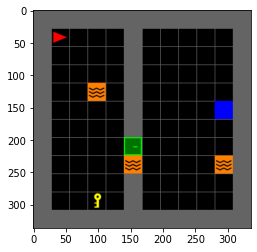

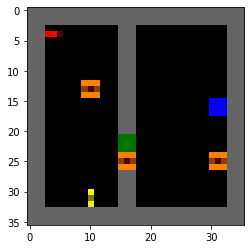

In [4]:
TILE_SIZE = 28
import gym
from minigrid.wrappers import RGBImgObsWrapper, ImgObsWrapper
env = gym.make('MiniGrid-DoorKeySpecial')
env = RGBImgObsWrapper(env, tile_size=TILE_SIZE) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field
obs = env.reset(keydist=True, doordist=True, goaldist=True,
                key_locations=[1,11], key_colors=[4,5], keydist_locations=[1,11],
                door_locations=[1,11], door_colors=[2,3], doordist_locations=[1,11],
                goal_locations=[1,11], goal_colors=[3,4], goaldist_locations=[1,11])[0] # This now produces an RGB tensor only
print(env.goal_lang)
print(env.goal)
plt.imshow(obs)
plt.figure(figsize=(4,4))
plt.imshow(downsize_obs(obs))

In [5]:
# left 0, right 1, forward 2, pickup 3, drop 4, toggle 5, done 6
def gen_trajs(env, num_trajs=1, keydist=True, doordist=True, goaldist=True,
              key_locations=[1,11], key_colors=[1,5], keydist_locations=[1,11],
              door_locations=[1,11], door_colors=[1,5], doordist_locations=[1,11],
              goal_locations=[1,11], goal_colors=[1,5], goaldist_locations=[1,11]):
    trajs = []
    for traj in range(num_trajs):
        #env.reset(agent_pos=agent_pos, obj_pos=obj_pos, obj_colors=obj_colors, obj_shapes=obj_shapes, scalar=scalar)
        obs = env.reset(keydist=keydist, doordist=doordist, goaldist=goaldist,
                        key_locations=key_locations, key_colors=key_colors, keydist_locations=keydist_locations,
                        door_locations=door_locations, door_colors=door_colors, doordist_locations=doordist_locations,
                        goal_locations=goal_locations, goal_colors=goal_colors, goaldist_locations=goaldist_locations)[0] # This now produces an RGB tensor only
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [],'goal': []}
        full_img_obs = []
        
        ################ Pick up key
        # turn right
        acts = [1]
        # navigate to goal key
        for i in range(env.goal[1]-1):
            acts.append(2)
        # turn left, forward, and pick up
        acts.extend([0,2,3,2,2])
        
        ############### Go to door and unlock
        door = env.goal[4] - env.goal[1]
        # turn to door
        if door > 0:
            acts.append(1)
        elif door < 0:
            acts.append(0)
        # go in door dir
        for i in range(abs(door)):
            acts.append(2)
        # turn to door
        if door > 0:
            acts.append(0)
        elif door < 0:
            acts.append(1)
        # go to door and unlock
        acts.extend([2,5,2,2])
        
        ############### Go to goal
        goal = env.goal[7] - env.goal[4]
        # turn to goal
        if goal > 0:
            acts.append(1)
        elif goal < 0:
            acts.append(0)
        # go in goal dir
        for i in range(abs(goal)):
            acts.append(2)
        # turn to goal
        if goal > 0:
            acts.append(0)
        elif goal < 0:
            acts.append(1)
        # go to goal
        acts.extend([2,2,2,2,2])
        
        for act in acts:
            full_img_obs.append(obs.copy())
            traj['acts'].append(act)
            no = env.step(act)[0]
            obs = no.copy()
            traj['goal'].append(env.goal)
        
        for obs in full_img_obs:
            traj['obs'].append(downsize_obs(obs.copy()))

        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        trajs.append(traj)
    return trajs

In [6]:
# generates random trajs within specified constraints
env = gym.make('MiniGrid-DoorKeySpecial')
env = RGBImgObsWrapper(env, tile_size=TILE_SIZE) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field

keydist=False
key_locations=[1,7]
key_colors=[2,3]
keydist_locations=[9,10]

doordist=False
door_locations=[6,7]
door_colors=[3,4]
doordist_locations=[9,10]

goaldist=False
goal_locations=[6,7]
goal_colors=[4,5]
goaldist_locations=[1,2]

train_trajs = gen_trajs(env, num_trajs=20, keydist=keydist, doordist=doordist, goaldist=goaldist,
                        key_locations=key_locations, key_colors=key_colors, keydist_locations=keydist_locations,
                        door_locations=door_locations, door_colors=door_colors, doordist_locations=doordist_locations,
                        goal_locations=goal_locations, goal_colors=goal_colors, goaldist_locations=goaldist_locations)

[1 2 0 2 3 2 2 1 2 2 2 2 0 2 5 2 2 2 2 2 2 2]


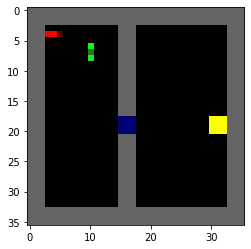

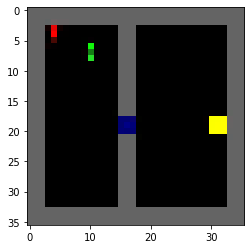

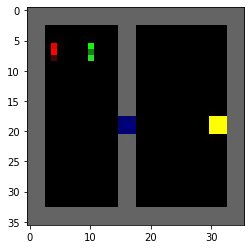

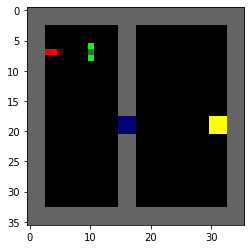

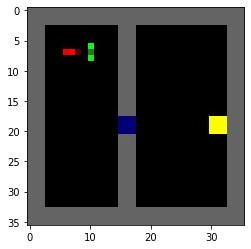

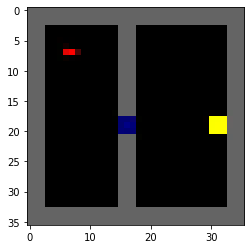

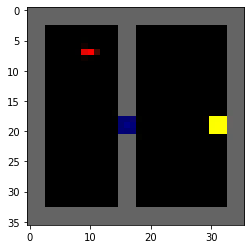

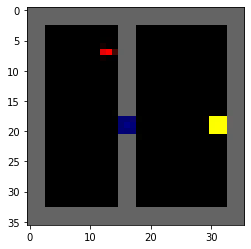

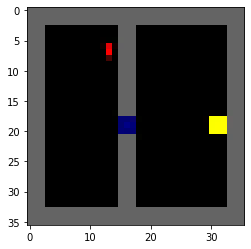

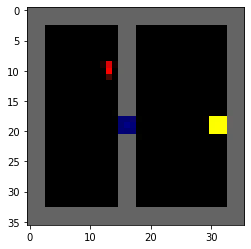

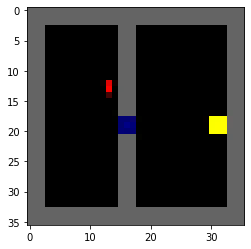

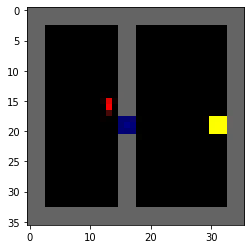

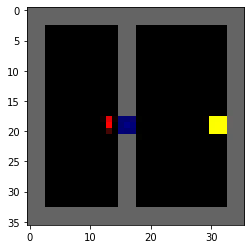

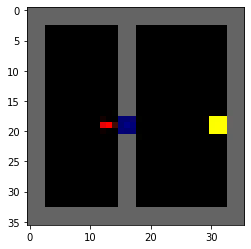

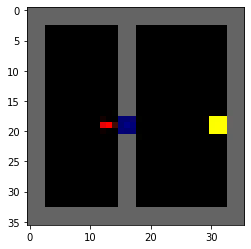

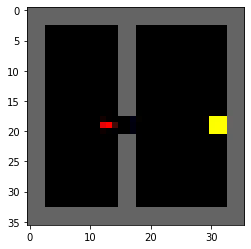

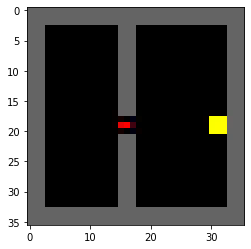

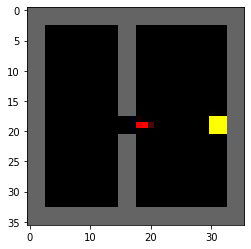

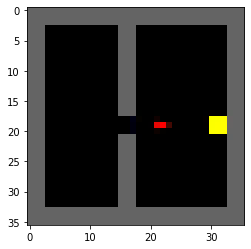

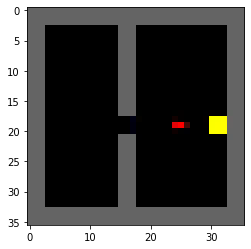

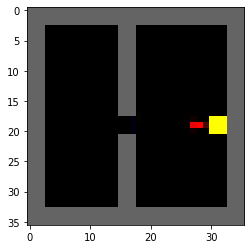

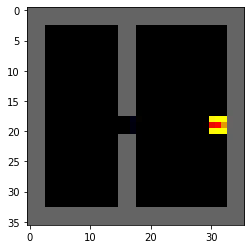

In [7]:
temp = 0
print(train_trajs[temp]['acts'])
for i in range(len(train_trajs[temp]['obs'])):
    plt.figure()
    plt.imshow(train_trajs[temp]['obs'][i])

In [8]:
num_tasks = len(train_trajs)

goal_size = 9 #384
act_size = 7
hidden_size = 100
mask = False

policy = CNNPolicy(goal_size, act_size, hidden_size, mask=mask)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

CNNPolicy(
  (goal): Sequential(
    (0): Linear(in_features=9, out_features=100, bias=True)
  )
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten()
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=32, out_features=100, bias=True)
  )
  (process): Sequential(
    (0): Linear(in_features=200, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=1296, bias=True)
    (3): Sigmoid()
  )
  (cnntrunk): Sequential(
    (0): Conv2

[1,     1] loss: 1.55031884
[1,     1] action loss: 1.55031884
[2,     1] loss: 1.14893222
[2,     1] action loss: 1.14893222
[3,     1] loss: 0.92166299
[3,     1] action loss: 0.92166299
[4,     1] loss: 0.82158715
[4,     1] action loss: 0.82158715
[5,     1] loss: 0.74948996
[5,     1] action loss: 0.74948996
[6,     1] loss: 0.70425040
[6,     1] action loss: 0.70425040
[7,     1] loss: 0.63982916
[7,     1] action loss: 0.63982916
[8,     1] loss: 0.57606810
[8,     1] action loss: 0.57606810
[9,     1] loss: 0.52911961
[9,     1] action loss: 0.52911961
[10,     1] loss: 0.48734814
[10,     1] action loss: 0.48734814
[11,     1] loss: 0.43471426
[11,     1] action loss: 0.43471426
[12,     1] loss: 0.40575615
[12,     1] action loss: 0.40575615
[13,     1] loss: 0.37320924
[13,     1] action loss: 0.37320924
[14,     1] loss: 0.33576319
[14,     1] action loss: 0.33576319
[15,     1] loss: 0.30000016
[15,     1] action loss: 0.30000016
[16,     1] loss: 0.26845604
[16,     1] ac

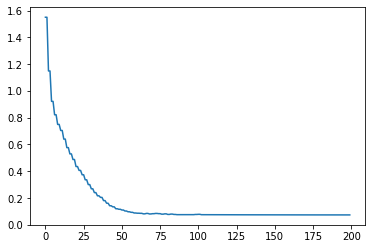

In [9]:
num_epochs = 100
batch_size = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(train_trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()
        
        obs = np.concatenate([traj['obs'] for traj in train_trajs])
        acts = np.concatenate([traj['acts'] for traj in train_trajs])
        goals = np.concatenate([traj['goal'] for traj in train_trajs])

        #t_idx = np.random.randint(len(train_trajs), size=(batch_size,)) # Indices of traj
        #t_idx_pertraj = np.random.randint(traj_horizon, size=(batch_size,)) # Indices of timesteps in traj
        #t_states = np.concatenate([train_trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        #t_goals = np.concatenate([train_trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
        #t_actions = np.concatenate([train_trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t_idx, t_idx_pertraj)])
   
        t_states = torch.Tensor(obs).float().to(device)
        t_goals = torch.Tensor(goals).float().to(device)
        t_actions = torch.Tensor(acts).long().to(device)
        
        if mask:
            a_preds, masked_state_preds, img_mask_preds = policy(t_goals, t_states)
            mask_loss = 5e-8*masked_state_preds.sum()
            #mask_loss = 0
        else:
            a_preds = policy(t_goals, t_states)[0]
        
        action_loss = criterion(a_preds, t_actions) # supervised learning loss
        if mask:
            loss = action_loss + mask_loss
        else:
            loss = action_loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            #print('[%d, %5d] mask loss: %.8f' %
            #      (epoch + 1, i + 1, mask_loss))
            print('[%d, %5d] action loss: %.8f' %
                  (epoch + 1, i + 1, action_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

['go to the green key blue door yellow goal']
tensor([[ 3.,  6.,  2.,  5.,  6.,  3., 10.,  6.,  4.]])


RuntimeError: running_mean should contain 46208 elements not 32

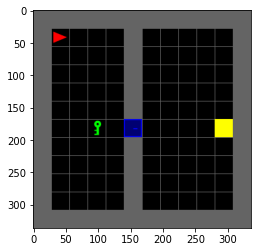

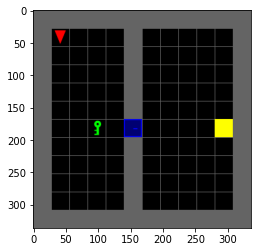

In [10]:
env = gym.make('MiniGrid-DoorKeySpecial')
env = RGBImgObsWrapper(env, TILE_SIZE) # Get pixel observations
env = ImgObsWrapper(env) # Get rid of the 'mission' field

keydist=False
key_locations=[6,7]
key_colors=[2,3]
keydist_locations=[1,7]

doordist=False
door_locations=[6,7]
door_colors=[3,4]
doordist_locations=[9,10]

goaldist=False
goal_locations=[6,7]
goal_colors=[4,5]
goaldist_locations=[1,2]

policy.eval()
num_test_trajs = 1
traj_horizon = 35
dist_to_goals = []
img = []

for i in range(num_test_trajs):
    obs = env.reset(keydist=keydist, doordist=doordist, goaldist=goaldist,
                    key_locations=key_locations, key_colors=key_colors, keydist_locations=keydist_locations,
                    door_locations=door_locations, door_colors=door_colors, doordist_locations=doordist_locations,
                    goal_locations=goal_locations, goal_colors=goal_colors, goaldist_locations=goaldist_locations)[0]
    show_step(obs)
    img.append(obs.copy())
    obs = downsize_obs(obs.copy())
    goal = torch.Tensor(env.goal[None]).to(device)
    print(env.goal_lang)
    print(goal)
    
    traj = {'obs': [],'acts': [], 'true_goal': [], 'masked_states': [], 'masks': []}
    for i in range(traj_horizon):
        state = torch.Tensor(obs[None]).to(device)
        if mask:
            action, masked_state, img_mask = policy(goal,state)
            action = torch.argmax(action.cpu().detach()[0]).numpy()
            masked_state = masked_state.cpu().detach().numpy()[0].transpose((1,2,0))
            img_mask = img_mask.cpu().detach().numpy()[0].transpose((1,2,0))
            traj['masked_states'].append(masked_state)
            traj['masks'].append(img_mask)
            show_step(masked_state)
        else:
            action = policy(goal,state)[0]
            action = torch.argmax(action.cpu().detach()).numpy()
        traj['obs'].append(obs.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal_lang)
        no = env.step(action)[0]
        show_step(no)
        img.append(no.copy())
        obs = no.copy()
    dist_to_goals.append(-np.linalg.norm((env.agent_pos - env.goal_location)))
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    #traj['masked_states'] = np.array(traj['masked_states'])
    traj['masks'] = np.array(traj['masks'])
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))

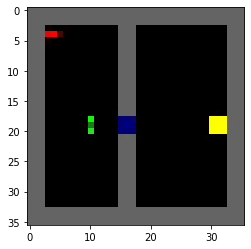

In [11]:
temp = 0
plt.imshow(traj['obs'][temp])
lime_obs = traj['obs'][temp]#.transpose(2,0,1)
lime_goal = goal.cpu().detach()[0].tolist()

In [12]:
def batch_predict(goals, obs):
    policy.eval()
    policy.to(device)
    
    obs = torch.Tensor(obs).to(device)
    batches = obs.shape[0]
    goals = torch.Tensor([goals]).to(device)
    goals = goals.repeat(batches, 1)
    #obs = torch.stack((obs, goals), dim=0)
    
    logits = policy(goals, obs)[0]
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [13]:
from functools import partial
g = partial(batch_predict, lime_goal)
test_pred = g([lime_obs])
test_pred.squeeze().argmax()

1

In [14]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(lime_obs), 
                                         g, # prediction function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

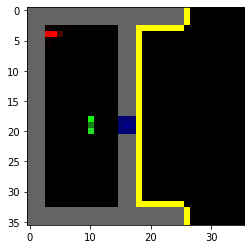

In [15]:
from skimage.segmentation import mark_boundaries
temp, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask1)
plt.imshow(img_boundry1)

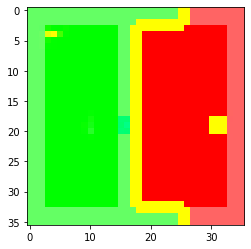

In [16]:
temp, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask1)
plt.imshow(img_boundry2)